In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sb
import pandas as pd

In [2]:
data_orig = pd.read_csv("train.csv")
test_orig = pd.read_csv("test.csv")
data = data_orig
test = test_orig
data=data.drop(['PassengerId'],axis=1)
full_data=[data,test]
data.columns


Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Embarked    0.002245
Age         0.198653
Cabin       0.771044
dtype: float64


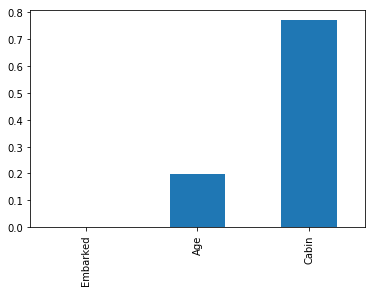

In [3]:
missing = data.isnull().mean()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
print(missing)
missing.plot.bar()

Fare     0.002392
Age      0.205742
Cabin    0.782297
dtype: float64


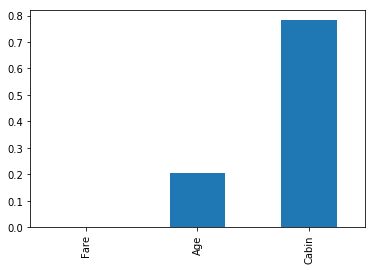

In [4]:
missing_test = test.isnull().mean()
missing_test = missing_test[missing_test > 0]
missing_test.sort_values(inplace=True)
print(missing_test)
missing_test.plot.bar()

In [5]:
import re
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
def univariate(dataset):
    dataset.loc[dataset.Embarked.isnull(),'Embarked']='S'
    dataset['Cabin']=dataset.Cabin.astype(str).str[0]
    dataset.Cabin=dataset.Cabin.astype('category')
    dataset['age_missing']=dataset.Age.isnull().astype(int)
    dataset.Age = dataset.Age.fillna(data.Age.median())
    #dataset['name_paranthesis']=dataset.Name.astype(str).str
    #dataset.name_paranthesis = (dataset.Name.str.find('(')!=-1).astype(int)
    dataset['name_length']=dataset.Name.astype(str).apply(len)
    dataset['child']=dataset.Age < 18
    dataset.Ticket=dataset.Ticket.astype(str).str[0].str.isnumeric()
#    dataset.Ticket=dataset.Ticket.astype('category')
    dataset['Ticket_length']=dataset.Ticket.astype(str).apply(len)
    dataset['Title'] = dataset['Name'].apply(get_title)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['alone']=(dataset.Parch+data.SibSp==0)
    dataset=pd.get_dummies(dataset,columns=['Sex','Cabin','Embarked','Title','Pclass'])
    try:
        dataset=dataset.drop(['Title_Mr','Sex_male','Embarked_Q','Embarked_C','Cabin_T','Pclass_2','Name','Title_Rare'],axis=1)
    except:
        dataset=dataset.drop(['Title_Mr','Sex_male','Embarked_Q','Embarked_C','Name','Title_Rare'],axis=1)
    dataset.loc[dataset.Fare <= 0,'Fare']=1e-8
    dataset.Fare=dataset.Fare.apply(np.log)
    dataset.Fare=dataset.Fare.fillna(dataset.Fare.median())
    return dataset

data=univariate(data)
test=univariate(test)

In [6]:
test.Fare=test.Fare.fillna(test.Fare.median())

In [7]:
test.Fare.isnull().mean()
test.columns
data.columns

Index(['Survived', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'age_missing',
       'name_length', 'child', 'Ticket_length', 'alone', 'Sex_female',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_n', 'Embarked_S', 'Title_Master', 'Title_Miss',
       'Title_Mrs', 'Pclass_1', 'Pclass_3'],
      dtype='object')

In [8]:
from sklearn.preprocessing import StandardScaler
std=StandardScaler()



data[['Fare','Parch','Age','SibSp','name_length','Ticket_length']]=std.fit_transform(data[['Fare','Parch','Age','SibSp','name_length','Ticket_length']])
test[['Fare','Parch','Age','SibSp','name_length','Ticket_length']]=std.transform(test[['Fare','Parch','Age','SibSp','name_length','Ticket_length']])


In [9]:
data.Ticket=data.Ticket.astype(int)


In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
train=data.drop(['Survived'],axis=1)
y=data_orig[['Survived']]

In [11]:
X_d,X_t,y_d,y_t = train_test_split(train,y,test_size=0.2)

In [12]:
logit=LogisticRegression()
logit.fit(X_d,y_d)
print('logit train score:',logit.score(X_d,y_d))
print('logit test score: ',logit.score(X_t,y_t))
print('logit CV mean score: ',cross_val_score(logit,X_d,y=np.ravel(y_d.Survived),cv=5).mean())
print('logit CV std score: ',cross_val_score(logit,X_d,y=np.ravel(y_d.Survived),cv=5).std())


/usr/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


logit train score: 0.84691011236
logit test score:  0.821229050279
logit CV mean score:  0.830165768703
logit CV std score:  0.0282624890545


In [13]:
def weight(estimator,train):
    beta=abs(estimator.coef_)
    st=np.array(train.apply(np.std,axis=0))
    weight = np.multiply(beta,st)/np.sum(np.multiply(beta,st))
    weight = pd.DataFrame(data=weight,columns=X_d.columns)
    return(weight)

w=weight(logit,X_d)
w=w[w.columns[(-w.iloc[0]).argsort()]]
w.T.iloc[0:10]

0
Sex_female    0.151300
SibSp         0.099486
Pclass_3      0.085884
Title_Master  0.082758
Age           0.060914
Title_Mrs     0.059084
Parch         0.057049
Title_Miss    0.055731
name_length   0.054597
Cabin_n       0.042892

In [14]:
logitCVL2=LogisticRegressionCV(penalty='l2',Cs=100)
logitCVL2.fit(train,np.ravel(y))

LogisticRegressionCV(Cs=100, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [15]:
logitCVL2.C_

array([ 0.75646333])

In [15]:
logitL2=LogisticRegression(penalty='l2',C=0.756)
logitL2.fit(X_d,y_d)
print('logit L2 train score:',logitL2.score(X_d,y_d))
print('logit L2 test score: ',logitL2.score(X_t,y_t))
print('logit L2 CV mean score: ',cross_val_score(logitL2,X_d,y=np.ravel(y_d.Survived),cv=5).mean())
print('logit L2 CV std score: ',cross_val_score(logitL2,X_d,y=np.ravel(y_d.Survived),cv=5).std())
w=weight(logitL2,X_d)
w=w[w.columns[(-w.iloc[0]).argsort()]]
w.T.iloc[0:10]

/usr/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


logit L2 train score: 0.84691011236
logit L2 test score:  0.810055865922
logit L2 CV mean score:  0.831564370102
logit L2 CV std score:  0.0267280473466


0
Sex_female    0.150671
SibSp         0.099356
Pclass_3      0.086580
Title_Master  0.077606
Age           0.062551
Title_Mrs     0.058566
name_length   0.057681
Title_Miss    0.056599
Parch         0.056361
Cabin_n       0.044606

In [16]:
logitCVL1=LogisticRegressionCV(penalty='l1',Cs=100,solver='liblinear')
logitCVL1.fit(train,np.ravel(y))

LogisticRegressionCV(Cs=100, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [18]:
logitCVL2.C_

array([ 0.75646333])

In [17]:
def output(estimator):
    print('train score:',estimator.score(X_d,y_d))
    print('test score: ',estimator.score(X_t,y_t))
    print('CV mean score: ',cross_val_score(estimator,X_d,y=np.ravel(y_d.Survived),cv=5).mean())
    print('CV std score: ',cross_val_score(estimator,X_d,y=np.ravel(y_d.Survived),cv=5).std())

In [18]:
logitL1=LogisticRegression(penalty='l1',C=0.756,solver='liblinear')
logitL1.fit(X_d,y_d)
print('logit L1 train score:',logitL1.score(X_d,y_d))
print('logit L1 test score: ',logitL1.score(X_t,y_t))
print('logit L1 CV mean score: ',cross_val_score(logitL1,X_d,y=np.ravel(y_d.Survived),cv=5).mean())
print('logit L1 CV std score: ',cross_val_score(logitL1,X_d,y=np.ravel(y_d.Survived),cv=5).std())
w=weight(logitL1,X_d)
w=w[w.columns[(-w.iloc[0]).argsort()]]
w.T.iloc[0:10]

/usr/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


logit L1 train score: 0.842696629213
logit L1 test score:  0.832402234637
logit L1 CV mean score:  0.834331885276
logit L1 CV std score:  0.0215222704698


0
Sex_female    0.259568
Title_Master  0.112075
SibSp         0.108832
Pclass_3      0.103304
Cabin_n       0.070177
Parch         0.063041
Age           0.062388
name_length   0.055574
Embarked_S    0.041514
alone         0.040145

In [20]:
w.T

0
Sex_female     0.251872
SibSp          0.099246
Pclass_3       0.093107
Title_Master   0.087483
Cabin_n        0.075688
Age            0.058109
Parch          0.057418
name_length    0.053614
Embarked_S     0.042574
Fare           0.039937
alone          0.025396
Cabin_C        0.024809
Cabin_E        0.021624
Pclass_1       0.021558
child          0.020905
Title_Mrs      0.013903
Cabin_A        0.005953
Ticket_length  0.003504
Cabin_D        0.003300
age_missing    0.000000
Cabin_F        0.000000
Cabin_G        0.000000
Ticket         0.000000
Title_Miss     0.000000
Cabin_B        0.000000

In [19]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_d,y_d)
print('tree train score:',tree.score(X_d,y_d))
print('tree test score: ',tree.score(X_t,y_t))
print('tree CV mean score: ',cross_val_score(tree,X_d,y=np.ravel(y_d.Survived),cv=5).mean())
print('tree CV std score: ',cross_val_score(tree,X_d,y=np.ravel(y_d.Survived),cv=5).std())

tree train score: 0.997191011236
tree test score:  0.731843575419
tree CV mean score:  0.778031438145
tree CV std score:  0.0213751436772


In [21]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(DecisionTreeClassifier(),param_grid={'max_depth': [2,3,4,5,6,7,8,9,10]})
grid.fit(X_d,y=np.ravel(y_d))

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [22]:
grid.best_estimator_.max_depth
output(grid.best_estimator_)
w=grid.best_estimator_.feature_importances_
w=pd.DataFrame(data=w,index=X_d.columns,columns=['tree'])
w.sort_values('tree',ascending=False)

train score: 0.877808988764
test score:  0.765363128492
CV mean score:  0.818877905632
CV std score:  0.0303486593507


tree
Sex_female     0.498693
Fare           0.120683
Pclass_3       0.119941
SibSp          0.064804
Title_Master   0.064712
Age            0.059262
Cabin_n        0.046655
name_length    0.011918
Parch          0.009163
Cabin_C        0.004169
Cabin_F        0.000000
Pclass_1       0.000000
Title_Mrs      0.000000
Title_Miss     0.000000
Embarked_S     0.000000
Cabin_G        0.000000
Cabin_E        0.000000
child          0.000000
Cabin_D        0.000000
Ticket         0.000000
Cabin_A        0.000000
age_missing    0.000000
alone          0.000000
Ticket_length  0.000000
Cabin_B        0.000000

In [23]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_d,y_d)
output(svc)


/usr/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train score: 0.838483146067
test score:  0.810055865922
CV mean score:  0.828697803046
CV std score:  0.0257218303287


In [24]:
from sklearn.model_selection import RandomizedSearchCV
par_dist={'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1)}
rand=RandomizedSearchCV(SVC(),par_dist,n_iter=100,cv=5)
rand.fit(X_d,np.ravel(y_d))
rand.cv_results_

{'mean_fit_time': array([ 0.08871403,  0.08509264,  0.05153732,  0.05657964,  0.07721043,
         0.07987924,  0.10475831,  0.07284851,  0.10343328,  0.0538312 ,
         0.07826324,  0.11558909,  0.05698156,  0.07802057,  0.05411978,
         0.08670573,  0.08098707,  0.11243472,  0.08301644,  0.08773055,
         0.06074867,  0.17058439,  0.09253745,  0.05601864,  0.08670421,
         0.05446563,  0.07019615,  0.09326329,  0.11308198,  0.07965288,
         0.07882843,  0.10719643,  0.05418282,  0.12485752,  0.10119619,
         0.10386686,  0.07583961,  0.08394055,  0.07113614,  0.12513304,
         0.10047874,  0.1257813 ,  0.08655028,  0.11442761,  0.11436648,
         0.06879354,  0.13652439,  0.055862  ,  0.08575501,  0.08484159,
         0.07910047,  0.1279902 ,  0.09230933,  0.10024877,  0.11702456,
         0.08493543,  0.08257408,  0.06005225,  0.16716285,  0.06588225,
         0.064644  ,  0.13367987,  0.09217186,  0.08752699,  0.08082662,
         0.05831585,  0.06495619, 

In [25]:
print(rand.best_estimator_.gamma,rand.best_estimator_.C)

0.00802966515212 22.9200123596


In [26]:
output(rand.best_estimator_)

train score: 0.839887640449
test score:  0.804469273743
CV mean score:  0.834331885276
CV std score:  0.0248936738138


In [29]:
from sklearn.ensemble import GradientBoostingClassifier
gb=GradientBoostingClassifier()
gb.fit(X_d,y_d)
output(gb)
w=gb.feature_importances_
w=pd.DataFrame(data=w,index=X_d.columns,columns=['gb'])
w.sort_values('gb',ascending=False)

/usr/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train score: 0.918539325843
test score:  0.810055865922
CV mean score:  0.823063720816
CV std score:  0.0241577562685


gb
Fare           0.257787
Age            0.211889
name_length    0.150111
Sex_female     0.125391
SibSp          0.050740
Pclass_3       0.030844
Embarked_S     0.025073
Cabin_E        0.023354
Title_Master   0.022417
Title_Miss     0.020341
Cabin_G        0.016597
Cabin_n        0.015307
Parch          0.013693
Pclass_1       0.010955
Cabin_C        0.005719
Cabin_B        0.004660
Cabin_D        0.004646
Title_Mrs      0.003219
age_missing    0.002990
Cabin_A        0.002133
alone          0.000971
Ticket         0.000681
Ticket_length  0.000482
Cabin_F        0.000000
child          0.000000

In [ ]:
par = {'learning_rate':scipy.stats.uniform(0.01,0.9),'max_depth':[2,3,4,5,6,7,8,9,10],'max_features': range(2,26)}
rand = RandomizedSearchCV(GradientBoostingClassifier(),par,n_iter=100,cv=5)
rand.fit(X_d,np.ravel(y_d))